1. Yolov4의 Pretrained weight를 사용하여 강아지 좌표 가져오기
2. 해당 좌표를 input으로 학습시킨 Mobilenet model에 넣어 목줄/입마개/없음 으로 분류

# 필요한 라이브러리 불러오기

In [8]:
import tensorflow as tf
import sys
import cv2
import numpy as np
from glob import glob
import pandas as pd
import os
import math
import scipy as sp
import PIL
from models import Yolov4

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2, imagenet_utils
from sklearn.metrics import confusion_matrix

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# YOLO, Mobilenet 모델 불러오기

In [10]:
yolo_model = Yolov4(weight_path='./yolov4.weights',
               class_name_path='./class_names/coco_classes.txt')

nms iou: 0.413 score: 0.3
all weights read
load from ./yolov4.weights


c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
MobileNetV2Model= tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None)
x = GlobalAveragePooling2D()(MobileNetV2Model.output)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(3, activation='softmax', name = "output_node")(x)
# Input ~ Output 연결해주기
model = Model(inputs=MobileNetV2Model.input, outputs=predictions)

soft_model = load_model('../MobileNetV2-107-0.2315-0.9500.hdf5')
# sig_model = load_model('../MobileNetV2-089-0.3565-0.9250.hdf5')

# 이미지 경로 설정

In [12]:
location = '../dataset/predict_img/'
img_list = os.listdir(location)
len(img_list)

12

# Utils

In [13]:
# 이미지 전처리
def prepare_image(img):
    resize_img = cv2.resize(img, (224,224))
    img_array = image.img_to_array(resize_img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet_v2.preprocess_input(img_array_expanded_dims)

# classification 결과값 가져오기
def get_results(pred):
    class_num = pred.argmax(axis=-1)
    score = pred.max()
    
    if class_num == 0:
        class_txt = "leash"
    elif class_num == 1:
        class_txt = "muzzle"
    else:
        class_txt = "nothing"
    
    return class_num, score, class_txt

# 사진에 bbox 그려주기
def draw_bbox(img, score, class_txt, df, idx):
    scale = max(img.shape[0:2]) / 416
    line_width = int(2 * scale)

    color = list(np.random.random(size=3) * 255)
    cv2.rectangle(img, (int(df.iloc[idx].x1), int(df.iloc[idx].y1)), (int(df.iloc[idx].x2), int(df.iloc[idx].y2)), color, line_width)
    
    text = f'{class_txt} {score:.2f}'
    font = cv2.FONT_HERSHEY_DUPLEX
    font_scale = max(0.3 * scale, 0.3)
    thickness = max(int(1 * scale), 1)
    (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=thickness)[0]
    
    cv2.rectangle(img, (int(df.iloc[idx].x1) - line_width//2, int(df.iloc[idx].y1) - text_height), (int(df.iloc[idx].x1) + text_width, int(df.iloc[idx].y1)), color, cv2.FILLED)
    cv2.putText(img, text, (int(df.iloc[idx].x1), int(df.iloc[idx].y1)), font, font_scale, (255, 255, 255), thickness, cv2.LINE_AA)
    # x1 -> df.iloc[idx].x1
    return img

# 강아지 location값 가져오기
def get_location(model, location, img_list, i):
    df = model.predict(location + img_list[i], random_color=True)
    
    # set threshold
    df = df[df.score>0.7] 
    return df

# classification 진행
def start_classficiation(model, img, dog_img, df, idx=0):
    input_img = prepare_image(dog_img)
    
    pred = model.predict(input_img)[0]
    
    class_num, score, class_txt = get_results(pred)
    
    img = draw_bbox(img, score, class_txt, df, idx)
    
    return img

# 전체 결과 subplot에 저장
def show_imgs(img_list, result_img, i):
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10*len(img_list)))
    plt.subplot(len(img_list)+1, 1, i+1)
    plt.imshow(result_img)
    plt.axis('off')

# 강아지 detection -> leash/muzzle/nothing classification

img shape:  (399, 600, 3)
1/1 [==============================] - 1s 1s/step
# of bboxes: 2
1/1 [==============================] - 0s 395ms/step
img shape:  (281, 500, 3)
1/1 [==============================] - 0s 43ms/step
# of bboxes: 5
1/1 [==============================] - 0s 14ms/step
img shape:  (164, 307, 3)
1/1 [==============================] - 0s 49ms/step
# of bboxes: 3
1/1 [==============================] - 0s 17ms/step
img shape:  (183, 275, 3)
1/1 [==============================] - 0s 46ms/step
# of bboxes: 6
1/1 [==============================] - 0s 14ms/step
img shape:  (506, 500, 3)
1/1 [==============================] - 0s 45ms/step
# of bboxes: 2
1/1 [==============================] - 0s 17ms/step
img shape:  (499, 640, 3)
1/1 [==============================] - 0s 44ms/step
# of bboxes: 2
1/1 [==============================] - 0s 15ms/step
img shape:  (532, 818, 3)
1/1 [==============================] - 0s 45ms/step
# of bboxes: 1
1/1 [==============================] -

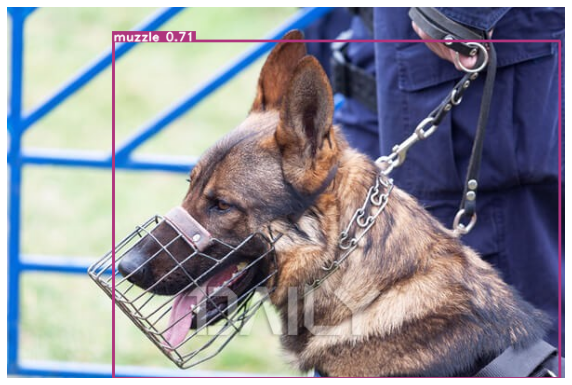

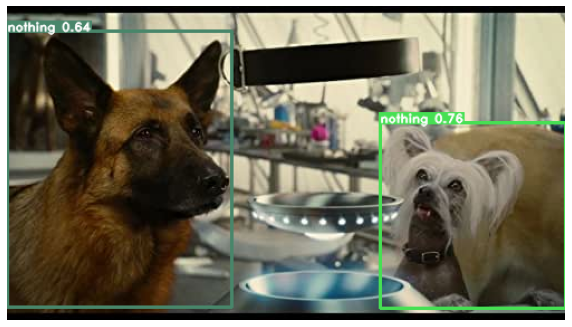

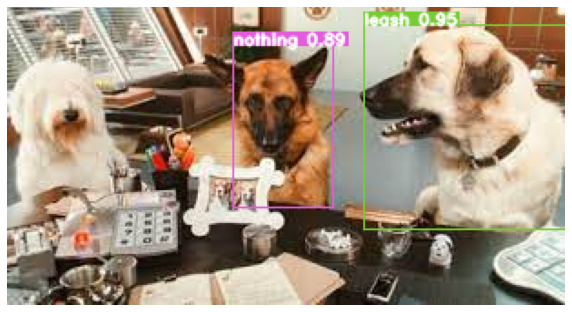

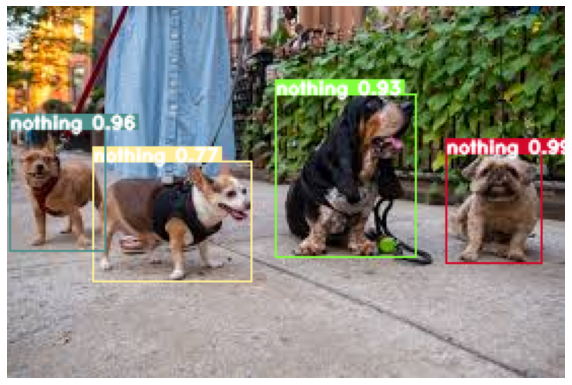

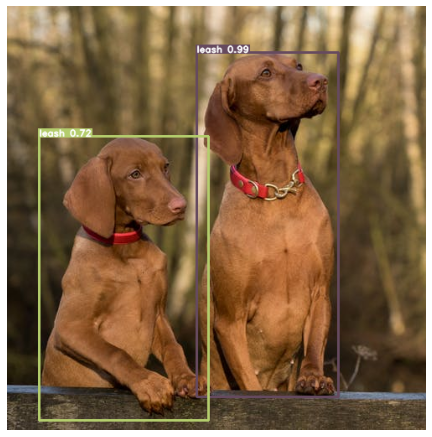

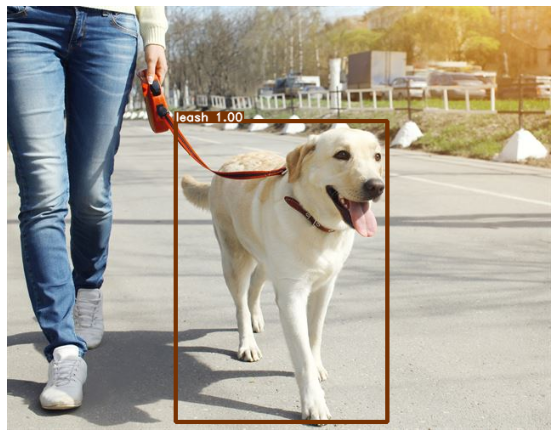

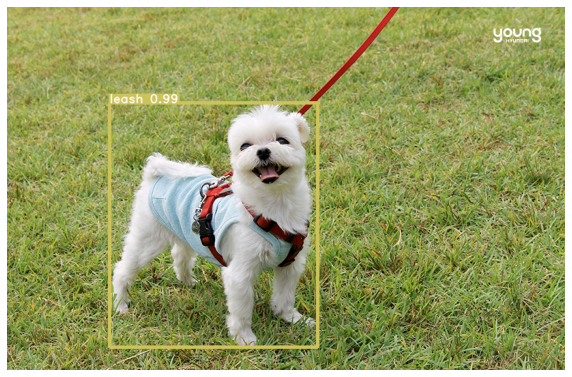

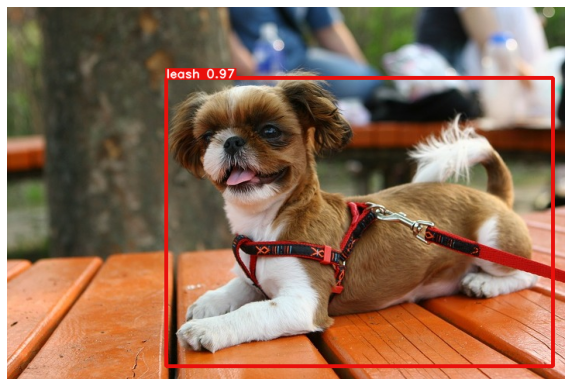

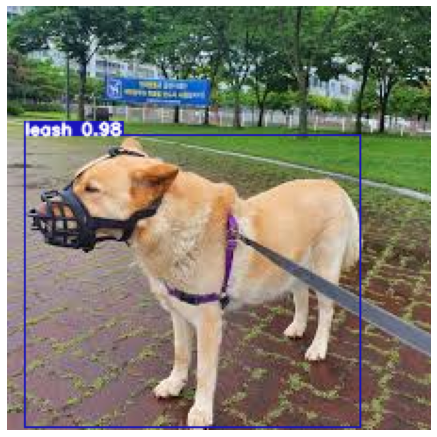

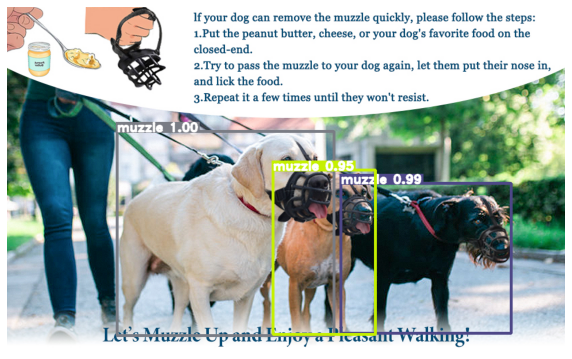

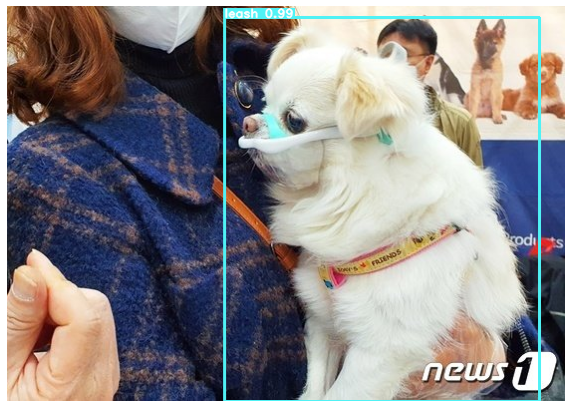

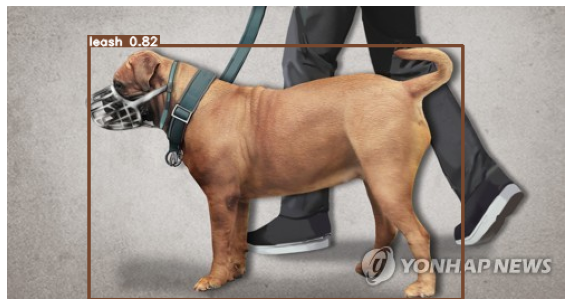

In [14]:
for i in range(len(img_list)):
    # Yolo모델로 강아지 detection
    df = get_location(yolo_model, location, img_list, i)
    
    # 해당 이미지 불러오기
    img = cv2.imread(location + img_list[i])
    
    if len(df) == 0:
        # 사진에 강아지가 없다면 진행하지 않음
        continue
    
    elif len(df) > 1:
        result_img = img
        for j in range(len(df)):
            dog_img = img[int(df.iloc[j].y1) : int(df.iloc[j].y2), int(df.iloc[j].x1) : int(df.iloc[j].x2), :]
            
            # result_img에 다음 강아지에 대한 bbox를 그려주어 사진 속 모든 강아지의 bbox를 한 장의 사진에 나타내준다.
            result_img = start_classficiation(soft_model, result_img, dog_img, df, j)
        show_imgs(img_list, result_img, i)
             
    else:
        dog_img = img[int(df.y1) : int(df.y2) , int(df.x1) : int(df.x2), :]
        
        result_img = start_classficiation(soft_model, img, dog_img, df)
        show_imgs(img_list, result_img, i)
        
plt.show()
        